In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# Load the dataset
df = pd.read_csv('/transactions_train.csv')


In [28]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0


In [29]:
# drop unnecessary columns
df=df.drop(['step', 'nameOrig','nameDest'], axis=1)


In [30]:
df.head()

,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0.0


In [31]:
# convert transaction type to categorical variables

df['type']=pd.Categorical(df['type'])
df=pd.get_dummies(df,columns=['type'],prefix=['type'])


In [32]:
df.head()

,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,False,False,False,True,False
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,False,False,False,True,False
2,181.00,181.0,0.00,0.0,0.0,1.0,False,False,False,False,True
3,181.00,181.0,0.00,21182.0,0.0,1.0,False,True,False,False,False
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,False,False,False,True,False


In [33]:

# Check for missing values in the target variable
print("Missing values in 'isFraud':", df['isFraud'].isnull().sum())

Missing values in 'isFraud': 1


In [34]:
# If there are missing values, handle them (here, we'll drop them)
df = df.dropna(subset=['isFraud'])

In [35]:
# Ensure no missing values in the target variable now
print("Missing values in 'isFraud' after handling:", df['isFraud'].isnull().sum())

Missing values in 'isFraud' after handling: 0


In [36]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

Class distribution before SMOTE:
isFraud
0.0    34718
1.0       70
Name: count, dtype: int64


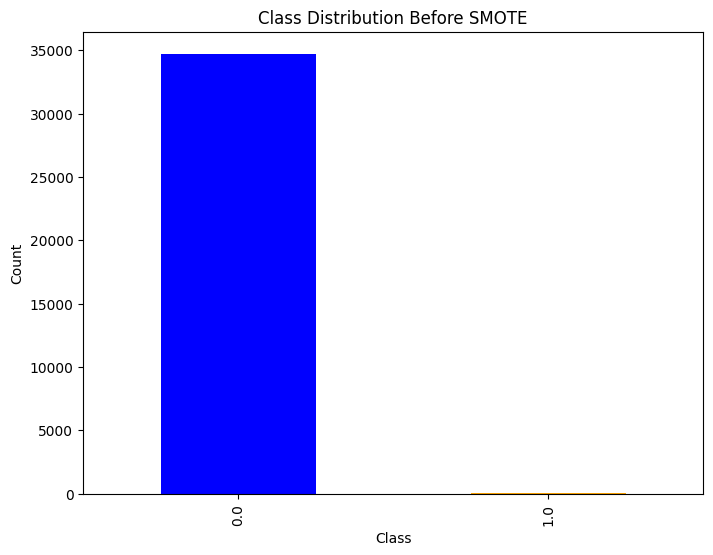

In [38]:
# Count the number of instances of each class before SMOTE
import matplotlib.pyplot as plt
count_before = y1_train.value_counts()
print("Class distribution before SMOTE:")
print(count_before)

# Visualize the class distribution before SMOTE
plt.figure(figsize=(8, 6))
count_before.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [39]:
# Perform oversampling using SMOTE (data balancing)
smote = SMOTE(random_state=42)
X_r, y_r = smote.fit_resample(X1_train, y1_train)

Class distribution after SMOTE:
isFraud
0.0    34718
1.0    34718
Name: count, dtype: int64


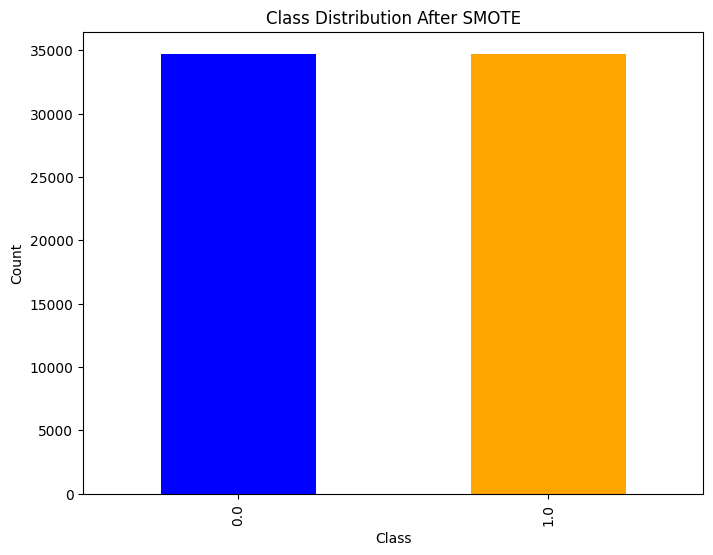

In [40]:
# Count the number of instances of each class after SMOTE
count_after = y_r.value_counts()
print("Class distribution after SMOTE:")
print(count_after)

# Visualize the class distribution after SMOTE
plt.figure(figsize=(8, 6))
count_after.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

In [42]:
# Train the Naive Bayes model and predict the probabilities
gnb = GaussianNB()
gnb.fit(X_train, y_train)
proba = gnb.predict_proba(X1_test)

In [43]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error


In [44]:
thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores = []
accuracies = []
recalls = []
precisions = []
for threshold in thresholds:
  predicted = (proba[:,1] >= threshold).astype(int)
  mse = mean_squared_error(y1_test, predicted)
  print(mse)
  f1_scores.append(f1_score(y1_test, predicted))
  accuracy = accuracy_score(y1_test, predicted)
  recall = recall_score(y1_test, predicted)
  precision = precision_score(y1_test, predicted)

  accuracies.append(accuracy)
  recalls.append(recall)
  precisions.append(precision)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

0.7891226859836725
0.7842934345176498
0.7787742899850523
0.775094860296654
0.7700356444751063
0.7630217316315971
0.7517534782108773
0.732896401057836
0.6618374152006439
Optimal Threshold: 0.9


In [45]:
accuracies

[0.21087731401632748,
 0.21570656548235023,
 0.22122571001494767,
 0.22490513970334597,
 0.22996435552489364,
 0.2369782683684029,
 0.24824652178912268,
 0.26710359894216396,
 0.3381625847993561]

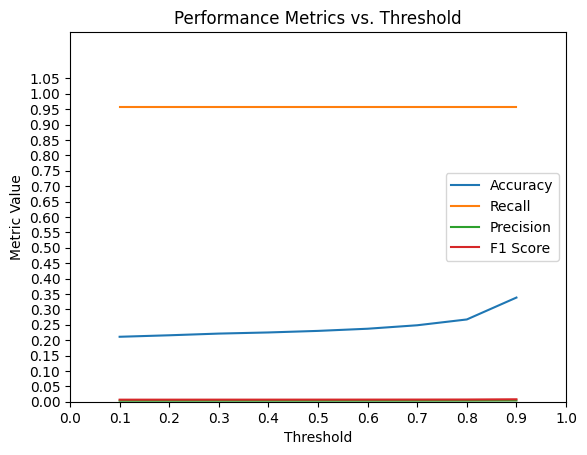

In [46]:
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.legend()
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.2)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Threshold')
plt.show()

In [47]:
# Classify the transactions as fraudulent or not based on the optimal threshold
predicted = (proba[:,1] >= optimal_threshold).astype(int)
fraud_probabilities = proba[:,1][predicted == 1]
print("Probability of Fraudulent Transactions:", fraud_probabilities)


Probability of Fraudulent Transactions: [0.92607704 0.91746736 0.93870683 ... 0.92974498 0.92914309 0.92558283]


In [48]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y1_test, predicted)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[2918 5755]
 [   1   23]]


In [49]:
from sklearn.metrics import accuracy_score
import numpy as np

In [50]:
optimal_threshold=1

In [51]:
# Classify the transactions as fraudulent or not based on the optimal threshold
predicted = (proba[:,1] >= optimal_threshold).astype(int)
accuracy = accuracy_score(y1_test, predicted)
print("Accuracy:", accuracy)

Accuracy: 0.9964355524893641
